In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import pickle
import cv2
%matplotlib inline

In [2]:
#load all the models
haar = cv2.CascadeClassifier('./model/haarcascade_frontalface_default.xml')
#pickle files
mean = pickle.load(open('./model/mean_preprocess.pickle','rb'))
model_svm = pickle.load(open('./model/model_svm.pickle','rb'))
model_pca = pickle.load(open('./model/pca_50.pickle','rb'))

print('Model loaded successfully')

Model loaded successfully


In [3]:
gender_pre = ['Male', 'Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [4]:
def pipeline_model(img, color='rgb'):
    #step2: convert into gray scale
    if color == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #step3: crop the face (using haar cascade classifier)
    faces = haar.detectMultiScale(gray,1.5,3)
    for x,y,w,h in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0),2) #drawing Rectangle
        roi = gray[y:y+h, x:x+w] #crop image
        #step4: normalization
        roi = roi/255.0
        #step5: resize images (100,100)
        if roi.shape[1]>100:
            roi_resize = cv2.resize(roi, (100,100), cv2.INTER_AREA)
        else:
            roi_resize = cv2.resize(roi, (100,100), cv2.INTER_CUBIC)
        #step6: Flattening (1 X 10000)
        roi_shape = roi_resize.reshape(1,10000) # 1, -1
        #step7: subtract with mean
        roi_mean = roi_shape - mean
        #step8: get eigen image
        eigen_image = model_pca.transform(roi_mean)
        #step9: pass to ml model (svm)
        results = model_svm.predict_proba(eigen_image)[0]
        #step10: 
        predict = results.argmax() # 0 or 1
        score = results[predict]
        #step11:
        text = "%s : %0.2f"%(gender_pre[predict], score)
        cv2.putText(img, text, (x,y), font,1,(0,255,0),2)
    
    return img

In [5]:
from PIL import Image

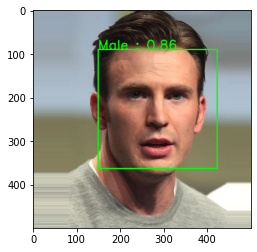

In [6]:
#test data
test_data_path = './data/male_000281.jpg'
color='bgr'
#step1: read image
img = Image.open(test_data_path) #rgb
#step2: convert into array
img = np.array(img)
#step3: pass to pipeline model
img = pipeline_model(img)
plt.imshow(img)

In [7]:
#apply pipeline model to video

In [11]:
cap = cv2.VideoCapture('./data/video.mp4')
while True:
    ret, frame = cap.read()
    
    if ret == False:
        break
    frame = pipeline_model(frame, color='bgr')
    
    cv2.imshow('Gender Detection',frame)
    if cv2.waitKey(10) == ord('s'):  #27 means esc key
        break

cv2.destroyAllWindows()
cap.release()